# OpenCV transformations
In this notebook we apply a number of transformations to images.

## Imports
Includes our own libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.imageutil import show_image

## Download images
You might be able to skip this if you already have the images from a previous run...

In [3]:
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki.tar.gz -P ./tmp/
# !tar -xf ./tmp/wiki.tar.gz -C ./tmp/

## Resizing/Scaling images
`cv2.resize(image, dsize(output image size), x scale, y scale, interpolation)`

- cv2.INTER_AREA - Good for shrinking or down sampling
- cv2.INTER_NEAREST - Fast
- cv2.INTER_LINEAR - Good for zooming or up sampling (default)
- cv2.INTER_CUBIC - Better
- cv2.INTER_LANCZOS4 - Best

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

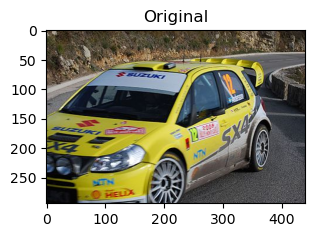

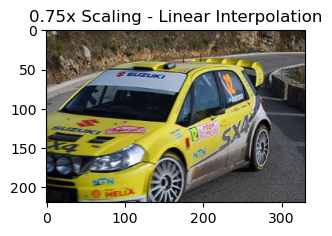

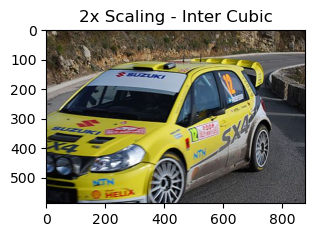

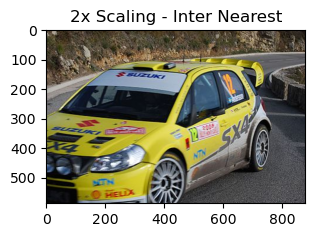

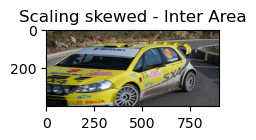

In [5]:
img = cv2.imread('tmp/wiki/04/11720204_1980-03-10_2008.jpg')
show_image(img, "Original")

img_scaled = cv2.resize(img, None, fx=0.75, fy=0.75)
show_image(img_scaled, "0.75x Scaling - Linear Interpolation")

img_scaled_2 = cv2.resize(img, None, fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
show_image(img_scaled_2, "2x Scaling - Inter Cubic")

img_scaled_3 = cv2.resize(img, None, fx=2, fy=2, interpolation = cv2.INTER_NEAREST)
show_image(img_scaled_3, "2x Scaling - Inter Nearest", )

img_scaled_4 = cv2.resize(img, (900, 400), interpolation = cv2.INTER_AREA)
show_image(img_scaled_4, "Scaling skewed - Inter Area")

## Down- Upsample image with image pyramids
`cv2.pyrUp(image)`, `cv2.pyrDown(image)`

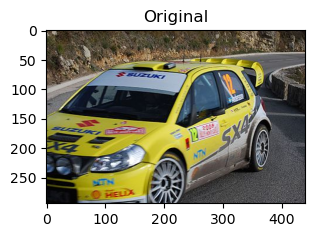

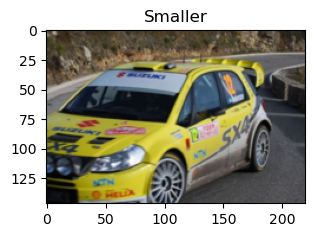

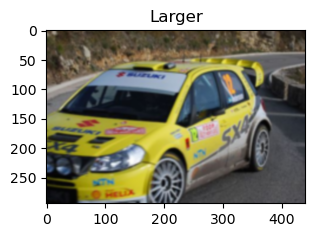

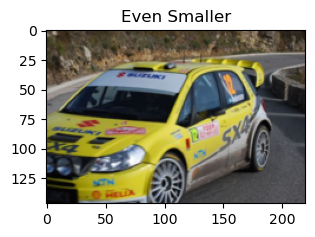

In [6]:
smaller = cv2.pyrDown(img)
larger = cv2.pyrUp(smaller)

show_image(img, "Original")
show_image(smaller, 'Smaller')
show_image(larger, 'Larger')

even_smaller = cv2.pyrDown(smaller)
show_image(smaller, 'Even Smaller')

## Cropping
We can crop an image by simply manipulating the image matrix with numpy.

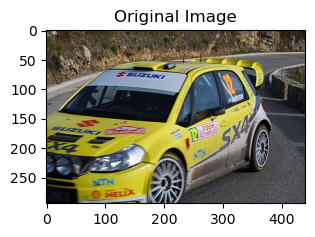

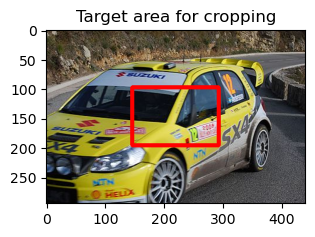

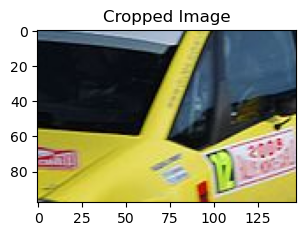

In [7]:
h, w = img.shape[:2]

# top left coordinates of cropping target 1/3, 1/3
start_row, start_col = int(h * (1/3)), int(w * (1/3))

# bottom right coordinates
end_row, end_col = int(h * (2/3)), int(w * (2/3))

cropped = img[start_row:end_row , start_col:end_col]

show_image(img, "Original Image")

# draw target cropping rectangle
copy = img.copy()
cv2.rectangle(copy, (start_col,start_row), (end_col,end_row), (0,0,255), 6)

show_image(copy, "Target area for cropping")

show_image(cropped, "Cropped Image") 

## Translations
Affine transform to shift image position.  
`cv2.warpAffine(image, T, (width, height))`

[[  1.    0.  110. ]
 [  0.    1.   73.5]]


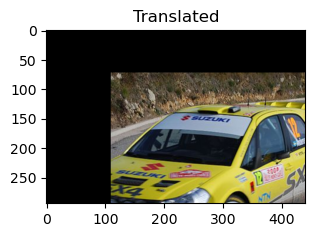

In [8]:
# shift image by quarter of the height and width
quarter_height, quarter_width = h/4, w/4

# translation matrix
#       | 1 0 Tx |
#  T  = | 0 1 Ty |
T = np.float32([[1, 0, quarter_width], [0, 1,quarter_height]])
print(T)

img_translation = cv2.warpAffine(img, T, (w, h))
show_image(img_translation, "Translated")

## Rotations
`cv2.getRotationMatrix2D(rotation_center_x, rotation_center_y, angle, scale)`

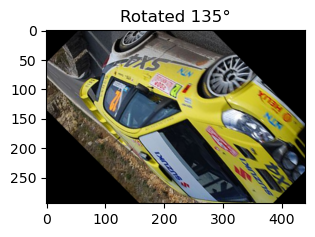

In [9]:
T = cv2.getRotationMatrix2D((w/2, h/2), 135, 1)
rotated = cv2.warpAffine(img, T, (w, h))
show_image(rotated, "Rotated 135°")

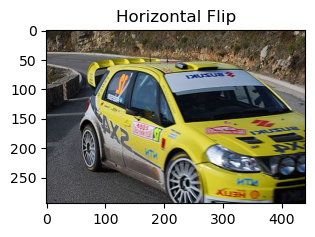

In [10]:
flipped = cv2.flip(img, 1)
show_image(flipped, "Horizontal Flip")

## Perspective transforms
We can use opencv to transform a skewed object to an orthogonal view.

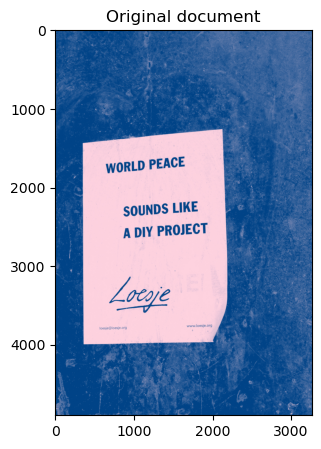

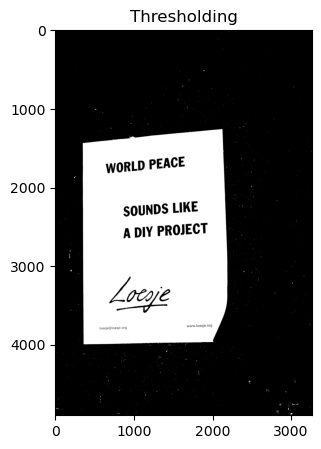

Contours found: 1536


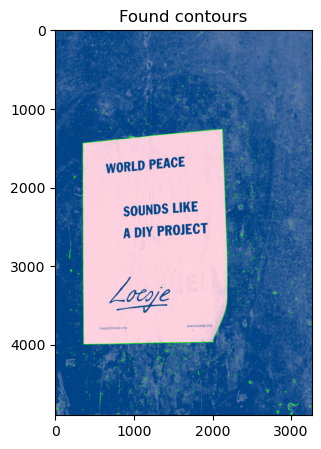

In [11]:
image = cv2.imread('../images/document.jpg')

show_image(image, "Original document")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show_image(threshold, "Thresholding")

contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Contours found: {len(contours)}")

cv2.drawContours(image, contours, -1, (0,255,0), 5)
show_image(image, 'Found contours')

Now we approximate the contour to just four points by using `cv2.approxPolyDP()`

Approximate corner points are: 
[[[2124 1259]]

 [[ 353 1439]]

 [[ 364 3995]]

 [[2013 3966]]]


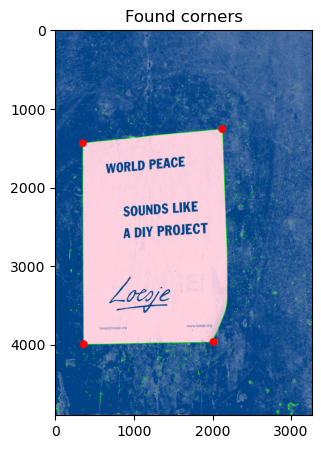

In [12]:
# sort contours by area
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

for contour in sorted_contours:
	perimeter = cv2.arcLength(contour, True)
	approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
 
	if len(approx) == 4:
		break 
        
print(f"Approximate corner points are: \r\n{approx}")
for p in approx:
    cv2.circle(image, (p[0][0], p[0][1]), 50, (0,0,255), -1)

show_image(image, 'Found corners')

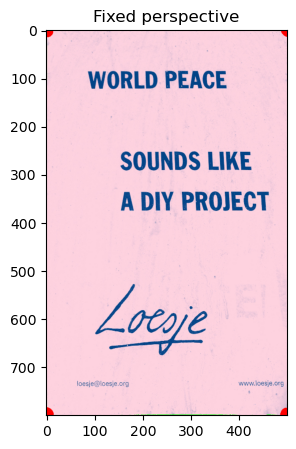

In [13]:
# order is: top right, top left, bottom left, bottom right
inputPoints = np.float32(approx)

outputPoints = np.float32([[500,0],
                           [0,0],
                           [0, 800],
                           [500,800]])

M = cv2.getPerspectiveTransform(inputPoints, outputPoints)
dst = cv2.warpPerspective(image, M, (500,800))

show_image(dst, "Fixed perspective")

## Image comparison
We can compare two images by calculating the mean squared error (MSE) or by using other metrics like `structural_similarity`

In [14]:
from skimage.metrics import structural_similarity
from lib.imageutil import mse

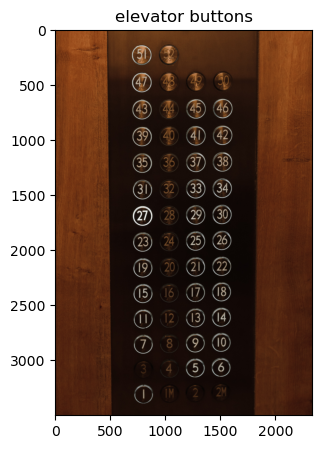

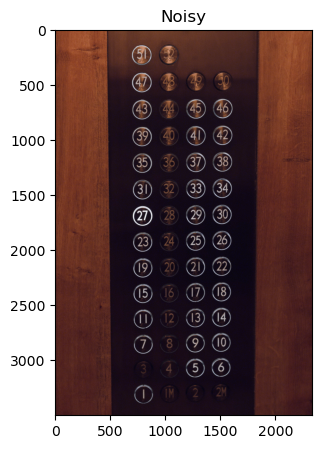

MSE elevator-elevator: 0.0
Structural similarity elevator-elevator: 1.0
MSE elevator-noisy_elevator: 799.0411768590998
Structural similarity elevator-noisy_elevator: 0.9200958299585548


In [21]:
elevator = cv2.imread('../images/elevator.jpg')
show_image(elevator, 'elevator buttons')

# add some gaussian noise
mean = 0
stddev = 40
noise = np.zeros(elevator.shape, np.uint8)
cv2.randn(noise, mean, stddev)
noisy_elevator = cv2.add(elevator, noise)
show_image(noisy_elevator, 'Noisy')

elevator_gray = cv2.cvtColor(elevator, cv2.COLOR_BGR2GRAY)
noisy_elevator_gray = cv2.cvtColor(noisy_elevator, cv2.COLOR_BGR2GRAY)

print(f'MSE elevator-elevator: {mse(elevator, elevator)}')
print(f'Structural similarity elevator-elevator: {structural_similarity(elevator_gray, elevator_gray)}')

print(f'MSE elevator-noisy_elevator: {mse(elevator, noisy_elevator)}')
print(f'Structural similarity elevator-noisy_elevator: {structural_similarity(elevator_gray, noisy_elevator_gray)}')
